# Predict infection progression

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../common_.py
import sys
sys.path.append("..")
from common import *

In [3]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import balanced_accuracy_score

from joblib import load

In [24]:
data_dir = Path("/home/maximl/scratch/data/vsc/datasets/weizmann/EhV/v2/results/scip/202202071958/")

In [25]:
df = pq.read_table(data_dir / "features.parquet").to_pandas()
cat_type = CategoricalDtype(categories=sorted(df["meta_group"].astype(int).unique()), ordered=True)
df["meta_group"] = df["meta_group"].astype(int).astype(cat_type)
df["meta_replicate"] = df["meta_replicate"].astype(int)

df = df.set_index(["meta_type", "meta_object_number", "meta_replicate", "meta_suffix", "meta_group"])

df = df[numpy.load(data_dir / "indices/columns.npy", allow_pickle=True)]
df = df.loc[numpy.load(data_dir / "indices/index_v3.npy", allow_pickle=True)]

df = df[df["meta_label"] != "unknown"]
df["meta_label"] = pandas.Categorical(df["meta_label"], categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)
df.shape

(105883, 914)

In [27]:
with open(data_dir / "rfe/xgb_features.txt", "r") as fh:
    optimal_features = [f[len("scip_"):] for f in fh.read().split(",")]

In [28]:
enc = LabelEncoder()
enc.classes_ = df.loc["Inf"]["meta_label"].cat.categories.values

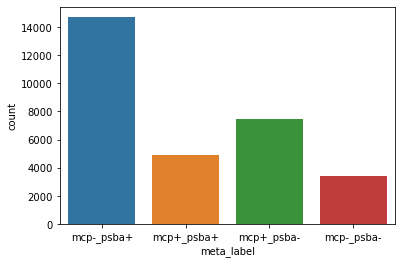

In [29]:
y = enc.transform(df.loc["Inf"]["meta_label"])
seaborn.countplot(x=df.loc["Inf"]["meta_label"])

In [30]:
# selection of the generic channel features for SCIP
to_keep = df.filter(regex=".*(BF1|BF2|DAPI|SSC)$").columns
Xs = df.loc["Inf"][to_keep]
Xs.shape

(30532, 583)

In [31]:
Xs_train, Xs_test, y_train, y_test = train_test_split(Xs, y, stratify=y, test_size=0.1, random_state=0)

In [32]:
df_train, df_test = train_test_split(df.loc["Inf"], stratify=y, test_size=0.1, random_state=0)

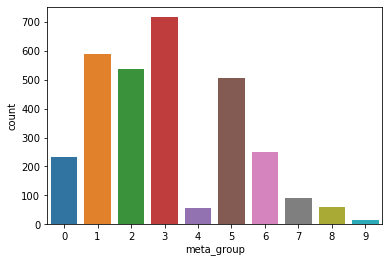

In [33]:
seaborn.countplot(data=df_test, x=df_test.index.get_level_values("meta_group"))

In [34]:
model_xgb_s = make_pipeline_imb(
    RandomOverSampler(random_state=0),
    load(data_dir / "models/xgb_rfe_with_index_v3.joblib")
)

In [35]:
y_pred = model_xgb_s.predict(Xs_test[optimal_features])

In [36]:
balanced_accuracy_score(y_test, y_pred)

0.8123080533894006

In [45]:
df_test["predicted state"] = pandas.Categorical(enc.inverse_transform(y_pred), categories=["mcp-_psba+", "mcp+_psba+", "mcp+_psba-", "mcp-_psba-"], ordered=True)

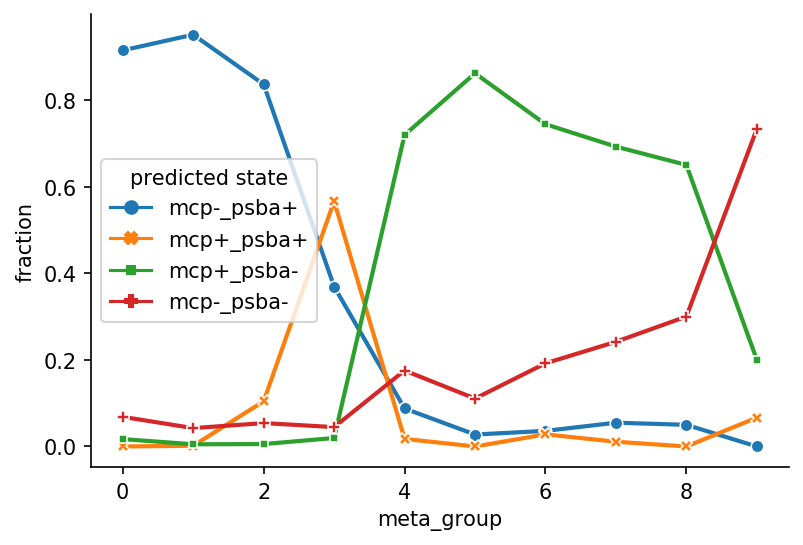

In [81]:
fraction_series = df_test.groupby(["meta_group", "predicted state"]).size() / df_test.groupby("meta_group").size()
fraction_series.name = "fraction"
fraction_series = fraction_series.to_frame().reset_index()

fig, ax = plt.subplots(dpi=150)
seaborn.lineplot(
    data=fraction_series, hue="predicted state", x="meta_group", y="fraction", 
    markers=True, style="predicted state", dashes=False, linewidth=2,
    ax=ax)
seaborn.despine(ax=ax)

plt.savefig(data_dir / "figures/predicted_progression.svg")

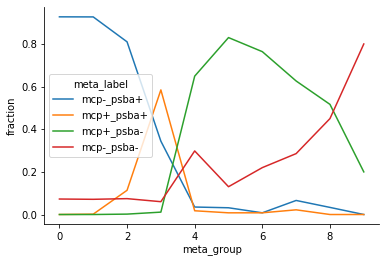

In [82]:
fraction_series_true = df_test.groupby(["meta_group", "meta_label"]).size() / df_test.groupby("meta_group").size()
fraction_series_true.name = "fraction"
fraction_series_true = fraction_series_true.to_frame().reset_index()
ax = seaborn.lineplot(data=fraction_series_true, hue="meta_label", x="meta_group", y="fraction")
seaborn.despine(ax=ax)

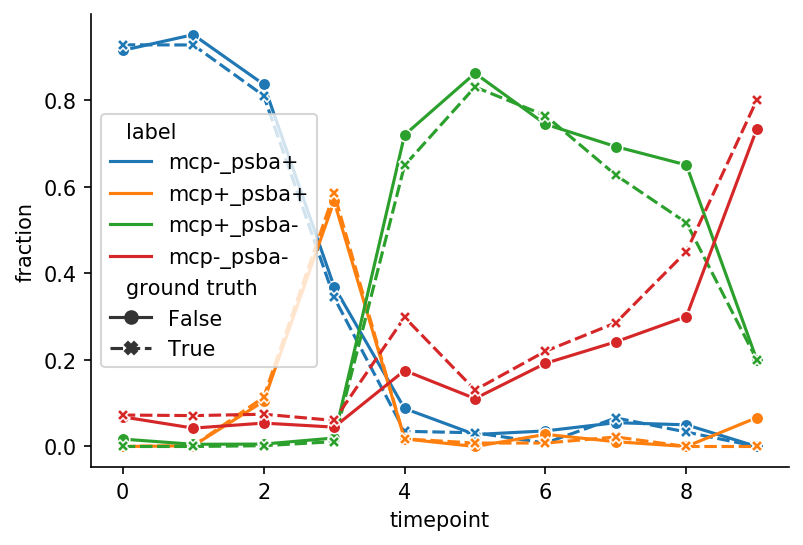

In [87]:
fraction_series_true["ground truth"] = True
fraction_series["ground truth"] = False
fraction_series.columns = ["timepoint", "label", "fraction", "ground truth"]
fraction_series_true.columns = ["timepoint", "label", "fraction", "ground truth"]

fig, ax = plt.subplots(dpi=150)
seaborn.lineplot(
    data=pandas.concat([fraction_series, fraction_series_true]).reset_index(), 
    hue="label", x="timepoint", y="fraction", style="ground truth",
    markers=True,
    ax=ax)
seaborn.despine(ax=ax)

plt.savefig(data_dir / "figures/predicted_progression.svg")